# Find the shadow edge in an image

In this notebook a demonstration is given how to find the shadow edge from an initial estimate. It uses a morphsnake, that either grows or shrinks towards a boundary.

### import of funcitons from libraries
First we need to import some generic libraries for plotting and file management

In [61]:
import matplotlib.pyplot as plt

import os
import numpy as np
import morphsnakes as ms

Than more specific functions can be imported from the **dhdt** library

In [21]:
from dhdt.generic.mapping_io import read_geo_image
from dhdt.generic.handler_sentinel2 import get_s2_image_locations, get_s2_dict
from dhdt.generic.gis_tools import get_mask_boundary

from dhdt.input.read_sentinel2 import list_central_wavelength_msi, read_stack_s2, s2_dn2toa, read_mean_sun_angles_s2

from dhdt.preprocessing.shadow_transforms import apply_shadow_transform
from dhdt.preprocessing.shadow_filters import enhance_shadows
from dhdt.preprocessing.image_transforms import mat_to_gray, inverse_tangent_transformation

from dhdt.postprocessing.solar_tools import make_shading, make_shadowing

### data preparation
Here some local data is taken, please adjust this to your own liking. A link to a Sentinel-2 directory is given, as well as, a link to a CopDEM elevation model of the same resolution.

In [3]:
dat_dir = '/Users/Alten005/surfdrive/Eratosthenes/RedGlacier/Sentinel-2/S2A_MSIL1C_20201019T213531_N0209_R086_T05VMG_20201019T220042.SAFE'

Z_file = "COP-DEM-05VMG.tif"
Z_dir = os.path.join('/Users/Alten005/surfdrive/Eratosthenes/RedGlacier/',
                      'Cop-DEM_GLO-30')

Z = read_geo_image(os.path.join(Z_dir, Z_file))[0]

A selection of bands is used here (only the 10m), and a random subset of the image is taken, so the details can be seen. Furthermore, most meta-data is extracted and put in a dataframe and a dictionary.

In [4]:
boi = ['red', 'green', 'blue', 'nir']
h,w = 100, 500
s2_df = list_central_wavelength_msi()
s2_df = s2_df[s2_df['common_name'].isin(boi)]
s2_df, datastrip_id = get_s2_image_locations(os.path.join(dat_dir, 'MTD_MSIL1C.xml'), s2_df)
s2_dict = get_s2_dict(s2_df)

Now the data can be loaded and cut to the subset.

In [12]:
im_stack, spatialRef, geoTransform, targetprj = read_stack_s2(s2_df)
im_stack = mat_to_gray(im_stack)
m,n = im_stack.shape[0], im_stack.shape[1]


In [ ]:
j_min, i_min = np.random.randint(w, n-w), np.random.randint(h, m-h)
j_max, i_max = j_min + w, i_min + h

For convenience, the data can be plotted. Here the near infrared band is shown.

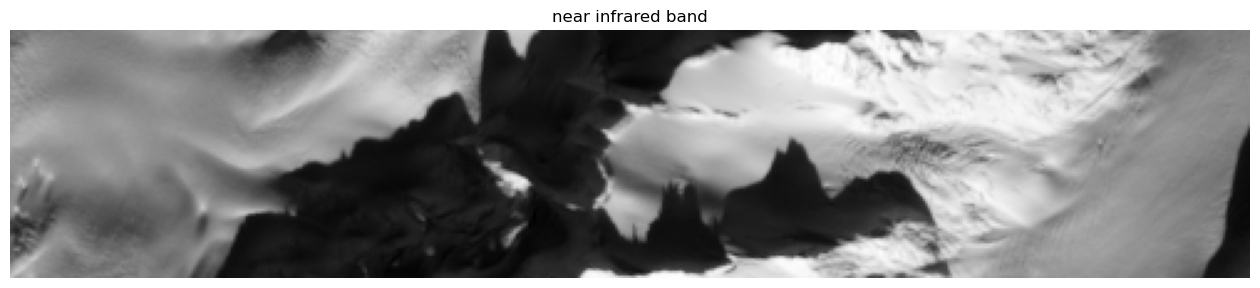

In [58]:
plt.rcParams['figure.figsize'] = [16.,4.]
plt.title('near infrared band'), 
plt.imshow(inverse_tangent_transformation(4*im_stack[i_min:i_max,j_min:j_max,-1]), cmap=plt.cm.gray), plt.axis('off');

In [65]:
im_stack = im_stack[i_min:i_max,j_min:j_max,:]

Since an elevation model is also loaded, a synthetic image can also be created. Which will hopefully ease the interpretation of the different methodologies later on.

In [59]:
sun_zn, sun_az = read_mean_sun_angles_s2(s2_dict['MTD_TL_path'])
Shw =  make_shadowing(Z.data, sun_az, sun_zn)
Shd =  make_shading(Z.data, sun_az, sun_zn)
Shw, Shd = Shw[i_min:i_max,j_min:j_max], Shd[i_min:i_max,j_min:j_max]

A visualization of a shading and a shadowing can now be created

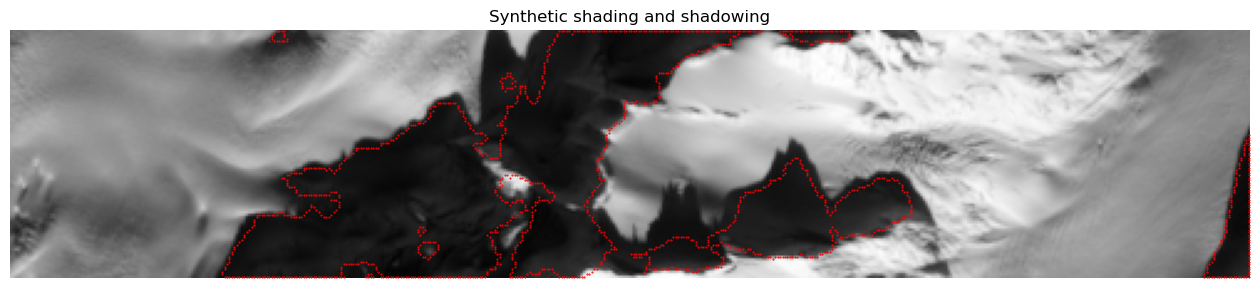

In [60]:
S_bnd = get_mask_boundary(Shw)
iB,jB = np.where(S_bnd)

plt.rcParams['figure.figsize'] = [16.,4.]
plt.title('Synthetic shading and shadowing'),
plt.imshow(inverse_tangent_transformation(4*im_stack[i_min:i_max,j_min:j_max,-1]), cmap=plt.cm.gray)
plt.scatter(jB,iB,1,'red','.'), plt.axis('off');

In [66]:
i_bl = np.flatnonzero(s2_df['common_name']=='blue')[0]
i_gr = np.flatnonzero(s2_df['common_name'] == 'green')[0]
i_rd = np.flatnonzero(s2_df['common_name']=='red')[0]
i_nr = np.flatnonzero(s2_df['common_name'] == 'nir')[0]
S,R = apply_shadow_transform('entropy',im_stack[...,i_bl], im_stack[...,i_gr],im_stack[...,i_rd],[],
                             im_stack[...,i_nr], [], a=138.)

In [91]:
counts = 50 # iterations
M = ms.morphological_chan_vese(S, counts, init_level_set=Shw, albedo=R,
                               smoothing=1, lambda1=1, lambda2=1)

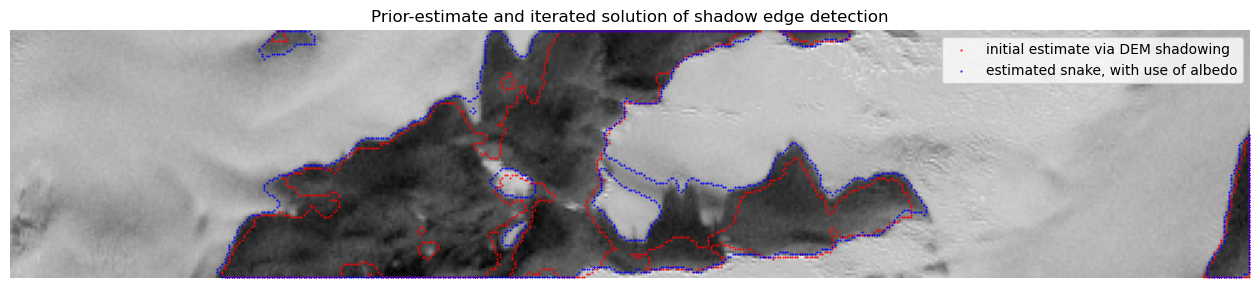

In [92]:
M_bnd = get_mask_boundary(M)
iM,jM = np.where(M_bnd)

plt.rcParams['figure.figsize'] = [16.,4.]
plt.title('Prior-estimate and iterated solution of shadow edge detection'),
plt.imshow(inverse_tangent_transformation(S), cmap=plt.cm.gray)
plt.scatter(jB,iB,1,'red','.'), plt.scatter(jM,iM,1,'blue','.'), plt.axis('off');
plt.legend({'initial estimate via DEM shadowing','estimated snake, with use of albedo'});